# Kaggle: Zillow Prize

In [7]:
import numpy as np
import pandas as pd
import missingno as msno
import re
%matplotlib inline

## Importing datasets

In [8]:
properties_path = 'https://s3.us-east-2.amazonaws.com/aws-emr-dedicated/data/zillow/properties_2016.csv'
train_path = 'https://s3.us-east-2.amazonaws.com/aws-emr-dedicated/data/zillow/train_2016_v2.csv'

properties = pd.read_csv(filepath_or_buffer=properties_path)
train = pd.read_csv(filepath_or_buffer=train_path)

/Users/ssss/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
properties.set_index('parcelid', inplace=True)
properties['latitude'] = properties['latitude']/1e6
properties['longitude'] = properties['longitude']/1e6

In [10]:
properties_in_train = properties.loc[train['parcelid'].drop_duplicates()]

In [11]:
print(properties.shape)
print(train.shape)
print(properties_in_train.shape)

(2985217, 57)
(90275, 3)
(90150, 57)


## Visualization of missing values

In [12]:
# missing percentage
properties_in_train.count().sort_values() / properties_in_train.shape[0]

buildingclasstypeid             0.000177
finishedsquarefeet13            0.000366
basementsqft                    0.000477
storytypeid                     0.000477
yardbuildingsqft26              0.001054
fireplaceflag                   0.002440
architecturalstyletypeid        0.002884
typeconstructiontypeid          0.003306
finishedsquarefeet6             0.004648
decktypeid                      0.007299
poolsizesum                     0.010715
pooltypeid10                    0.012856
pooltypeid2                     0.013356
taxdelinquencyflag              0.019689
taxdelinquencyyear              0.019689
hashottuborspa                  0.026212
yardbuildingsqft17              0.029340
finishedsquarefeet15            0.039434
finishedfloor1squarefeet        0.075984
finishedsquarefeet50            0.075984
fireplacecnt                    0.106456
threequarterbathnbr             0.133067
pooltypeid7                     0.184936
poolcnt                         0.198292
numberofstories 

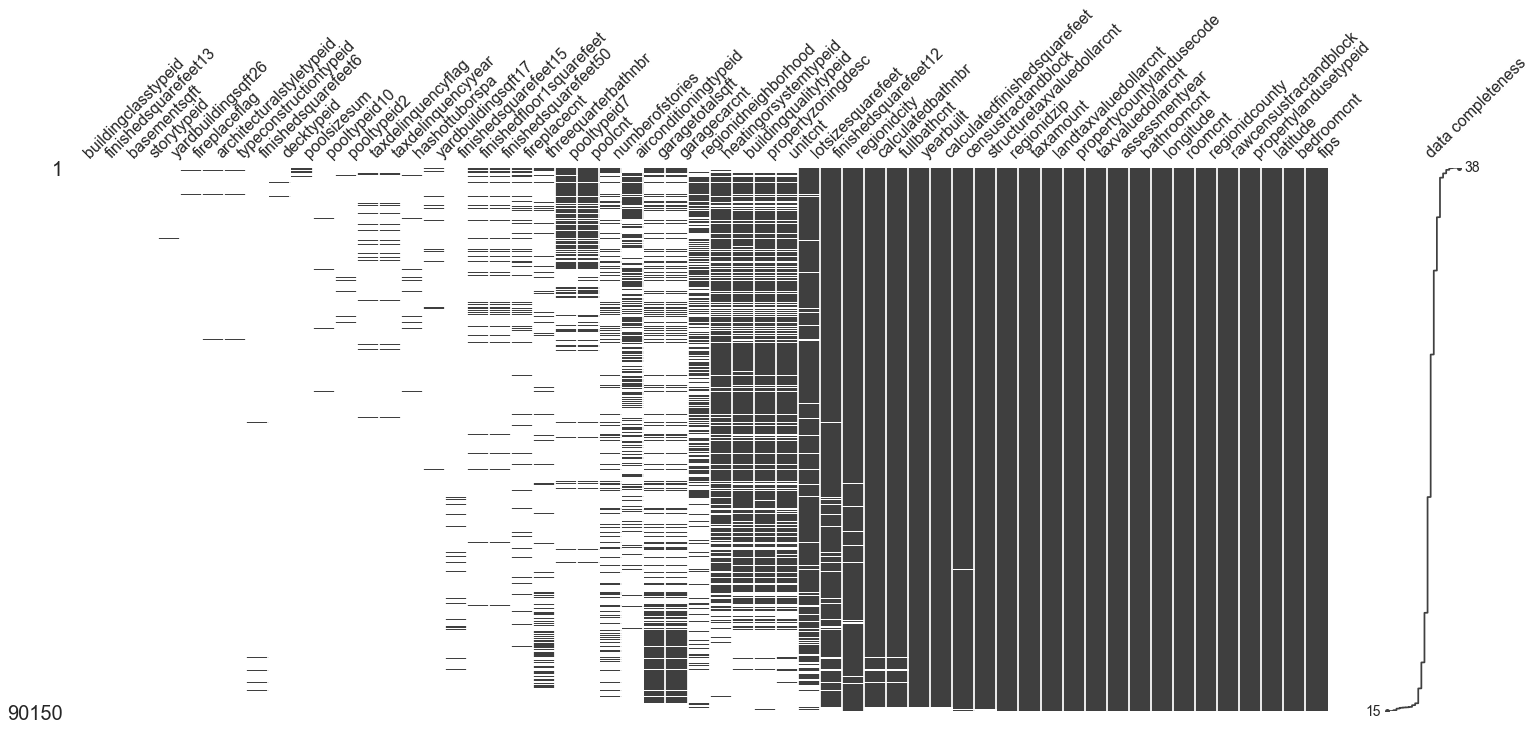

In [13]:
colnames = properties_in_train.count().sort_values().index
msno.matrix(msno.nullity_sort(properties_in_train[colnames], sort='descending'), 
            labels=True)

In [119]:
properties_in_train.head

<bound method NDFrame.head of           airconditioningtypeid  architecturalstyletypeid  basementsqft  \
parcelid                                                                  
11016594                    1.0                       0.0           0.0   
14366692                    0.0                       0.0           0.0   
12098116                    1.0                       0.0           0.0   
12643413                    1.0                       0.0           0.0   
14432541                    0.0                       0.0           0.0   
11509835                    1.0                       0.0           0.0   
12286022                    0.0                       0.0           0.0   
17177301                    0.0                       0.0           0.0   
14739064                    0.0                       0.0           0.0   
14677559                    0.0                       0.0           0.0   
10854446                    0.0                       0.0           0.

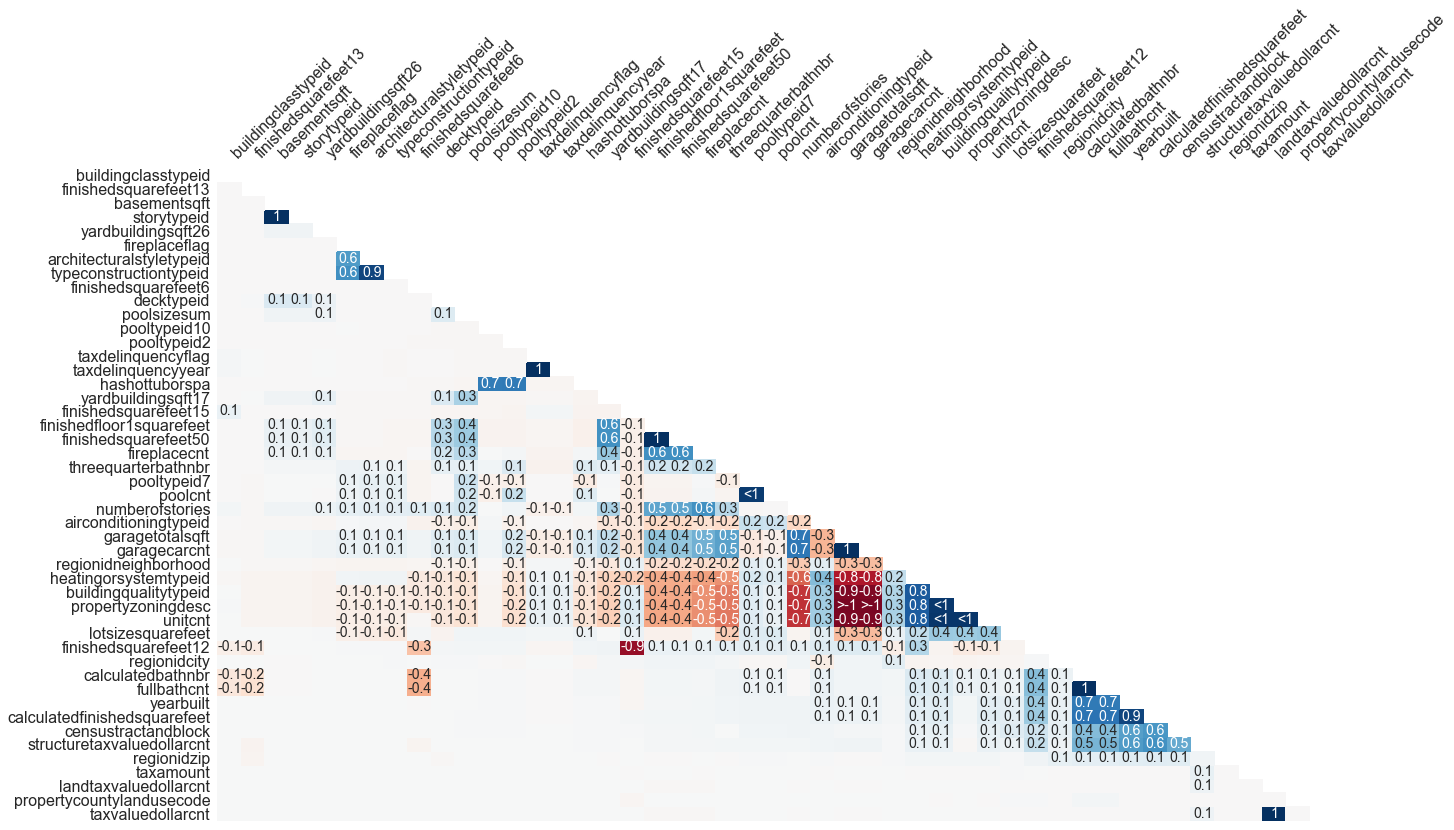

In [14]:
msno.heatmap(properties_in_train[colnames])

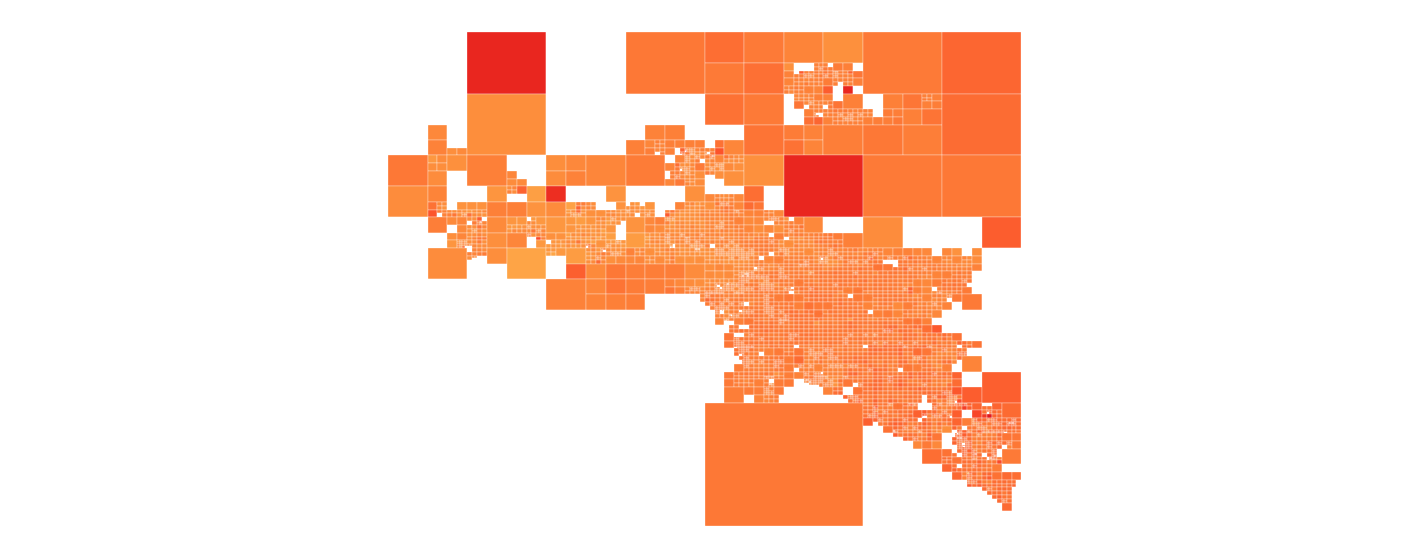

In [15]:
msno.geoplot(properties_in_train, 
             x='longitude', 
             y='latitude')

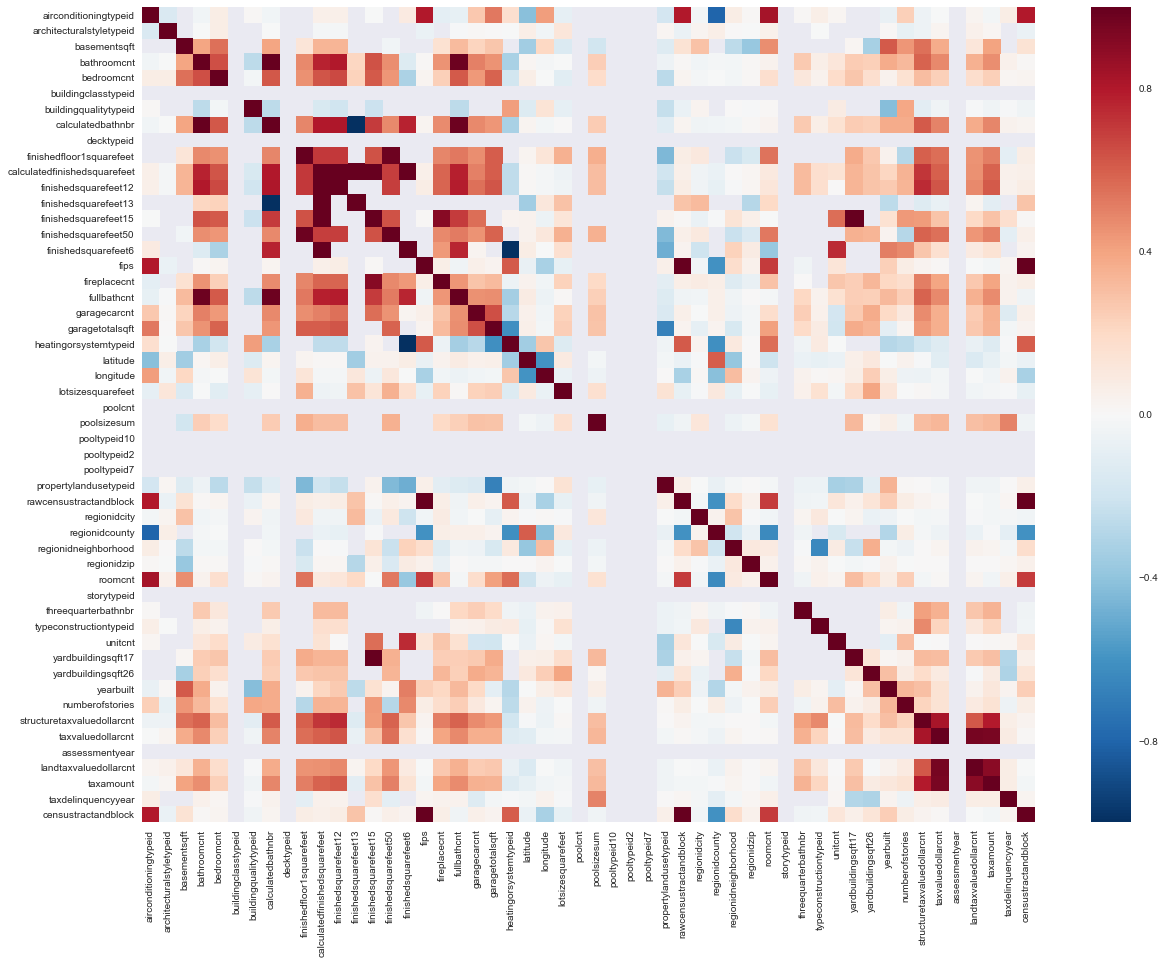

In [15]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(20,15))
corr = properties_in_train.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## Preprocessing data

In [20]:
# taxdelinquencyyear: Year for which the unpaid propert taxes were due 
properties_in_train['taxdelinquencyyear'].value_counts(dropna=False)

NaN      88375
 14.0      626
 15.0      515
 13.0      209
 12.0      153
 10.0       89
 11.0       84
 9.0        63
 8.0        24
 7.0         8
 6.0         3
 99.0        1
Name: taxdelinquencyyear, dtype: int64

In [21]:
def preproc_taxdelinquencyyear(data):
    col = 'taxdelinquencyyear'
    data.loc[data[col] < 20.0, col] = data.loc[data[col] < 20.0, col] + 2000
    data.loc[data[col] < 100.0, col] = data.loc[data[col] < 100.0, col] + 1900
    return data

In [22]:
properties_in_train = preproc_taxdelinquencyyear(properties_in_train)
properties = preproc_taxdelinquencyyear(properties)

In [23]:
# buildingclasstypeid: The building framing type (steel frame, wood frame, concrete/brick) 
print(properties['buildingclasstypeid'].value_counts(dropna=False))
print(properties_in_train['buildingclasstypeid'].value_counts(dropna=False))

NaN     2972588
 4.0       9265
 3.0       3161
 2.0         81
 1.0         65
 5.0         57
Name: buildingclasstypeid, dtype: int64
NaN     90134
 4.0       16
Name: buildingclasstypeid, dtype: int64


In [24]:
def categoryFilter(fit_data, transform_data=[], cols=[], fillna=None):
    for t_data in transform_data:
        for col in cols:
            levels = fit_data.loc[~fit_data[col].isnull(), col].unique()
            t_data.loc[~t_data[col].isin(levels), col] = np.nan
            t_data[col] = t_data[col]
        if fillna is not None:
            t_data = t_data.fillna(fillna)
        yield t_data

In [25]:
# fix categories in column buildingclasstypeid
# demo
a, b = categoryFilter(
    fit_data=properties_in_train, 
    transform_data=[properties_in_train, properties], 
    cols=['buildingclasstypeid'], 
)
print(a['buildingclasstypeid'].value_counts(dropna=False))
print(b['buildingclasstypeid'].value_counts(dropna=False))

NaN     90134
 4.0       16
Name: buildingclasstypeid, dtype: int64
NaN     2975952
 4.0       9265
Name: buildingclasstypeid, dtype: int64


In [26]:
drop_cols = [
    'fips', # fips is identical to regionidcounty
    'propertycountylandusecode',
    'censustractandblock',
    'propertyzoningdesc',
    'rawcensustractandblock',
    'regionidcity',
    'regionidneighborhood',
    'regionidzip',
    'assessmentyear', # same year
    'hashottuborspa',
    'taxdelinquencyflag',
]

# categorical columns
categorical_cols = [x for x in properties_in_train.columns if re.search('id$', x)]

In [27]:
for col in properties_in_train.columns:
    print('preprocessing {}...'.format(col))
    # drop columns
    if col in drop_cols:
        properties_in_train = properties_in_train.drop(col, axis=1)
        properties = properties.drop(col, axis=1)
    # fix categorical levels
    elif col in categorical_cols:
        properties_in_train, properties = categoryFilter(
            fit_data=properties_in_train, 
            transform_data=[properties_in_train, properties], 
            cols=[col], 
            fillna=0
        )
print('done!') 
#drop the column is the drop list
#fix the discrepencies of levels in training and testing datasets

preprocessing airconditioningtypeid...
preprocessing architecturalstyletypeid...
preprocessing basementsqft...
preprocessing bathroomcnt...
preprocessing bedroomcnt...
preprocessing buildingclasstypeid...
preprocessing buildingqualitytypeid...
preprocessing calculatedbathnbr...
preprocessing decktypeid...
preprocessing finishedfloor1squarefeet...
preprocessing calculatedfinishedsquarefeet...
preprocessing finishedsquarefeet12...
preprocessing finishedsquarefeet13...
preprocessing finishedsquarefeet15...
preprocessing finishedsquarefeet50...
preprocessing finishedsquarefeet6...
preprocessing fips...
preprocessing fireplacecnt...
preprocessing fullbathcnt...
preprocessing garagecarcnt...
preprocessing garagetotalsqft...
preprocessing hashottuborspa...
preprocessing heatingorsystemtypeid...
preprocessing latitude...
preprocessing longitude...
preprocessing lotsizesquarefeet...
preprocessing poolcnt...
preprocessing poolsizesum...
preprocessing pooltypeid10...
preprocessing pooltypeid2...


In [28]:
# impute na with -1 for numeric positive values
properties_in_train.fillna(-1, inplace=True)
properties.fillna(-1, inplace=True)

In [29]:
properties_in_train.dtypes

airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
heatingorsystemtypeid           float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
poolcnt                         float64


In [30]:
properties_in_train['fireplaceflag'].value_counts()

0       89930
True      220
Name: fireplaceflag, dtype: int64

In [31]:
from sklearn import preprocessing

# create a LabelEncoder instance
encoder = preprocessing.LabelEncoder()
# fit LabelEncoder
encoder.fit(properties_in_train['fireplaceflag'].astype(str))
# transform training set & test set based on training set
properties_in_train['fireplaceflag'] = encoder.transform(properties_in_train['fireplaceflag'].astype(str))
properties['fireplaceflag'] = encoder.transform(properties['fireplaceflag'].astype(str))

## Data Preparation

In [35]:
train_set = pd.merge(
    properties_in_train.dropna(axis=1), 
    train, 
    left_index = True, 
    right_on='parcelid'
)
train_set['month'] = pd.to_datetime(train_set['transactiondate']).dt.month
train_set = train_set.drop('parcelid', axis=1).drop('transactiondate', axis=1)

In [36]:
X = train_set.drop('logerror', axis=1)
y = train_set['logerror']

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=0)

## Cross Validation

### Linear Regressor

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

parameters = {'l1_ratio':np.arange(0.0, 0.1, 0.01),'alpha':np.logspace(-2, 2, 100),'normalize':[True]}

glm_reg = linear_model.ElasticNet()
glm_cv = GridSearchCV(glm_reg,
                     param_grid=parameters,
                     scoring='neg_mean_absolute_error',
                     cv=3)  
glm_cv.fit(X_train, y_train)

In [107]:
def feature_importance_coef(estimator, labels):
    feature_imp = pd.DataFrame.from_dict({'feature':labels,
                                          'importance':estimator.coef_})
    feature_imp.set_index('feature',
                          inplace=True, 
                          drop=True)
    feature_imp = feature_imp.sort_values('importance', ascending=False)
    feature_imp.plot.bar()

In [111]:
pd.DataFrame.from_dict({'feature':X_train.columns,'importance':glm_cv.best_estimator_.coef_})

,feature,importance
0,airconditioningtypeid,5.932438e-07
1,architecturalstyletypeid,9.858180e-07
2,basementsqft,1.196651e-07
3,bathroomcnt,6.545259e-06
4,bedroomcnt,5.788391e-06
5,buildingclasstypeid,-2.798000e-05
6,buildingqualitytypeid,-7.245068e-07
7,calculatedbathnbr,6.634567e-06
8,decktypeid,-1.544302e-07
9,finishedfloor1squarefeet,8.402085e-09


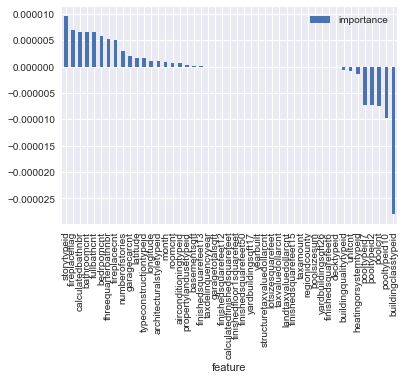

In [108]:
plt.figure(figsize=(20,15))
feature_importance_coef(glm_cv.best_estimator_, X_train.columns)

In [97]:
from sklearn.metrics import mean_absolute_error
#train error
print('glm - train error:')
print(mean_absolute_error(y_train, glm_cv.best_estimator_.predict(X_train)))

#test error
print('glm - test error:')
print(mean_absolute_error(y_test, glm_cv.best_estimator_.predict(X_test)))

# # 1st try
#l-ratio,0,1,0.3
# alpha, e-2,e2,100
# glm - train error:
# 0.0687201901119
# glm - test error:
# 0.0678291373718

glm - train error:
0.0687201901119
glm - test error:
0.0678291373718


# test linear model

In [115]:
gb_final = linear_model.ElasticNet(**glm_cv.best_params_)
gb_final.fit(X, y)

/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.0,
      max_iter=1000, normalize=True, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [116]:
test_set = properties
test_set['month'] = 11
test_pred = gb_final.predict(test_set)

prediction = pd.DataFrame.from_dict({'index':test_set.index,
                                     'predict':test_pred})
prediction.set_index('index')

prediction.columns=['ParcelId','201610']
prediction['201611']=prediction['201610']
prediction['201612']=prediction['201610']
prediction['201710']=0
prediction['201711']=0
prediction['201712']=0
prediction=prediction.round(4)
from pandas import ExcelWriter

# DF TO CSV
prediction.to_csv('PythonExport_linear.csv', sep=',',index=False)

### [RandomForestRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[5,10,20],'n_jobs':[-1],'oob_score':[False]}

rf_reg = RandomForestRegressor(verbose=1)
rf_cv = GridSearchCV(rf_reg,
                     param_grid=parameters,
                     scoring='neg_mean_absolute_error',
                     cv=3)  
rf_cv.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_job

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=1, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 20], 'n_jobs': [-1], 'oob_score': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [58]:
# best cv parameters
print(rf_cv.best_params_)

NameError: name 'rf_cv' is not defined

In [27]:
def feature_importance(estimator, labels):
    feature_imp = pd.DataFrame.from_dict({'feature':labels,
                                          'importance':estimator.feature_importances_})
    feature_imp.set_index('feature',
                          inplace=True, 
                          drop=True)
    feature_imp = feature_imp.sort_values('importance', ascending=False)
    feature_imp.plot.bar()

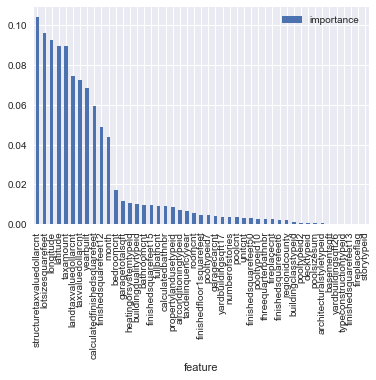

In [28]:
plt.figure(figsize=(20,15))
feature_importance(rf_cv.best_estimator_, X_train.columns)

### old test error  --DO NOT CHANGE

In [35]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, rf_cv.best_estimator_.predict(X_test))

[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished


0.077411905098232578

### new error from modified features  - CHECK overfitting/underfitting

In [7]:
#train error
print('rf - train error:')
print(mean_absolute_error(y_train, rf_cv.best_estimator_.predict(X_train)))

#test error
print('rf - test error:')
print(mean_absolute_error(y_test, rf_cv.best_estimator_.predict(X_test)))

rf - train error:


NameError: name 'y_train' is not defined

#### GradientBoostingRegressor

In [29]:
from sklearn.ensemble import GradientBoostingRegressor

parameters = {'n_estimators':[5, 10, 20],
              'learning_rate':[0.01, 0.1],
              'max_depth':[1,3,5]
             }

gb_reg = GradientBoostingRegressor(verbose=1)

gb_cv = GridSearchCV(gb_reg,
                     param_grid=parameters,
                     scoring='neg_mean_absolute_error',
                     cv=3)  
gb_cv.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.0260            0.06s
         2           0.0260            0.05s
         3           0.0260            0.03s
         4           0.0260            0.02s
         5           0.0260            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0254            0.07s
         2           0.0254            0.05s
         3           0.0254            0.04s
         4           0.0254            0.02s
         5           0.0254            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0257            0.07s
         2           0.0257            0.05s
         3           0.0257            0.03s
         4           0.0257            0.02s
         5           0.0257            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0260            0.18s
         2           0.0260            0.16s
         3           0.0260            0.14s
      

         3           0.0254            0.28s
         4           0.0253            0.14s
         5           0.0253            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0257            0.55s
         2           0.0257            0.42s
         3           0.0257            0.28s
         4           0.0256            0.14s
         5           0.0256            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0260            1.25s
         2           0.0260            1.07s
         3           0.0260            0.93s
         4           0.0259            0.80s
         5           0.0259            0.66s
         6           0.0259            0.53s
         7           0.0259            0.39s
         8           0.0259            0.27s
         9           0.0259            0.13s
        10           0.0259            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0254            1.32s
       

         5           0.0255            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0259            0.52s
         2           0.0259            0.49s
         3           0.0258            0.43s
         4           0.0258            0.38s
         5           0.0257            0.32s
         6           0.0257            0.26s
         7           0.0256            0.19s
         8           0.0256            0.13s
         9           0.0256            0.07s
        10           0.0255            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0253            0.56s
         2           0.0252            0.47s
         3           0.0251            0.43s
         4           0.0251            0.37s
         5           0.0250            0.32s
         6           0.0250            0.25s
         7           0.0249            0.19s
         8           0.0248            0.13s
         9           0.0248            0.06s
        

GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=1,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 20], 'learning_rate': [0.01, 0.1], 'max_depth': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [30]:
print(gb_cv.best_params_)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 5}


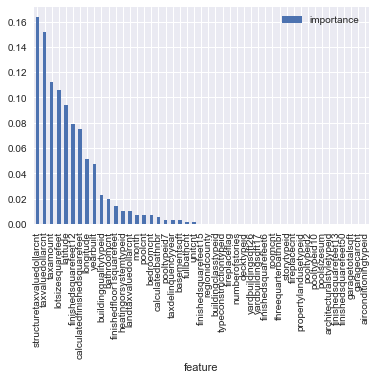

In [31]:
plt.figure(figsize=(20,15))
feature_importance(gb_cv.best_estimator_, X_train.columns)

### old test error  --DO NOT CHANGE

In [36]:
mean_absolute_error(y_test, gb_cv.best_estimator_.predict(X_test))

0.067551672844733568

### new error from modified features  - CHECK overfitting/underfitting

In [8]:
#train error
print('gbm - train error:')
print(mean_absolute_error(y_train, gb_cv.best_estimator_.predict(X_train)))

#test error
print('gbm - test error:')
print(mean_absolute_error(y_test, gb_cv.best_estimator_.predict(X_test)))

gbm - train error:


NameError: name 'y_train' is not defined

## Final model fit

In [37]:
gb_final = GradientBoostingRegressor(**gb_cv.best_params_)

In [38]:
gb_final.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=5, presort='auto',
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

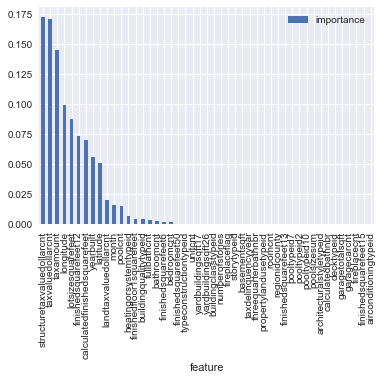

In [39]:
feature_importance(gb_final, X.columns)

In [112]:
test_set = properties
test_set['month'] = 11

test_pred = gb_final.predict(test_set)

NameError: name 'gb_final' is not defined

In [113]:
prediction = pd.DataFrame.from_dict({'index':test_set.index,
                                     'predict':test_pred})
prediction.set_index('index')

NameError: name 'test_pred' is not defined

In [70]:
prediction.columns=['ParcelId','201610']
prediction['201611']=prediction['201610']
prediction['201612']=prediction['201610']
prediction['201710']=0
prediction['201711']=0
prediction['201712']=0

In [72]:
prediction=prediction.round(4)

In [75]:
from pandas import ExcelWriter

# DF TO CSV
prediction.to_csv('PythonExport_round.csv', sep=',',index=False)

In [74]:
prediction.shape

(2985217, 7)